# Weather Time Series Project: Estes Park

Coded by Luna McBride

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #Plotting
%matplotlib inline

plt.rcParams['figure.figsize'] = (15,10) #Set the default figure size
plt.style.use('ggplot') #Set the plotting method

from statsmodels.tsa.stattools import grangercausalitytests #Causality Testing
from statsmodels.tsa.seasonal import seasonal_decompose #Seasonal Decomposition
from statsmodels.tsa.stattools import adfuller #Stationary Testing
from statsmodels.graphics.tsaplots import plot_acf #Compute lag for ARIMA
from statsmodels.graphics.tsaplots import plot_pacf #Compute partial lag for ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX #Build the model

from sklearn.metrics import mean_absolute_error #Error

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/weather-analysis/climate_data.csv


In [2]:
weather = pd.read_csv("../input/weather-analysis/climate_data.csv") #Read the weather CSV
weather.head() #Take a peek at the dataset

,Date,Average temperature (°F),Average humidity (%),Average dewpoint (°F),Average barometer (in),Average windspeed (mph),Average gustspeed (mph),Average direction (°deg),Rainfall for month (in),Rainfall for year (in),...,Maximum humidity (%),Minimum humidity (%),Maximum pressure,Minimum pressure,Maximum windspeed (mph),Maximum gust speed (mph),Maximum heat index (°F),Date1,Month,diff_pressure
0,2009-01-01,37.8,35.0,12.7,29.7,26.4,36.8,274.0,0.0,0.0,...,4.0,27.0,29.762,29.596,41.4,59.0,40.0,2009-01-01,1,0.166
1,2009-01-02,43.2,32.0,14.7,29.5,12.8,18.0,240.0,0.0,0.0,...,4.0,16.0,29.669,29.268,35.7,51.0,52.0,2009-01-02,1,0.401
2,2009-01-03,25.7,60.0,12.7,29.7,8.3,12.2,290.0,0.0,0.0,...,8.0,35.0,30.232,29.260,25.3,38.0,41.0,2009-01-03,1,0.972
3,2009-01-04,9.3,67.0,0.1,30.4,2.9,4.5,47.0,0.0,0.0,...,7.0,35.0,30.566,30.227,12.7,20.0,32.0,2009-01-04,1,0.339
4,2009-01-05,23.5,30.0,-5.3,29.9,16.7,23.1,265.0,0.0,0.0,...,5.0,13.0,30.233,29.568,38.0,53.0,32.0,2009-01-05,1,0.665


---

# Check for Null Values

In [3]:
print(weather.isnull().any()) #Check for nulls

Date                        False
Average temperature (°F)    False
Average humidity (%)        False
Average dewpoint (°F)       False
Average barometer (in)      False
Average windspeed (mph)     False
Average gustspeed (mph)     False
Average direction (°deg)    False
Rainfall for month (in)     False
Rainfall for year (in)      False
Maximum rain per minute     False
Maximum temperature (°F)    False
Minimum temperature (°F)    False
Maximum humidity (%)        False
Minimum humidity (%)        False
Maximum pressure            False
Minimum pressure            False
Maximum windspeed (mph)     False
Maximum gust speed (mph)    False
Maximum heat index (°F)     False
Date1                       False
Month                       False
diff_pressure               False
dtype: bool


There are no null values, but there seems to be some columns that I find unnecessary for what I would like to do. Columns like month does not seem necessary. I also should check if the date fields are the same.

---

# Removing Columns

In [4]:
print(weather.loc[weather["Date"] != weather["Date1"]]) #Check if the date fields are the same

Empty DataFrame
Columns: [Date, Average temperature (°F), Average humidity (%), Average dewpoint (°F), Average barometer (in), Average windspeed (mph), Average gustspeed (mph), Average direction (°deg), Rainfall for month (in), Rainfall for year (in), Maximum rain per minute, Maximum temperature (°F), Minimum temperature (°F), Maximum humidity (%), Minimum humidity (%), Maximum pressure, Minimum pressure, Maximum windspeed (mph), Maximum gust speed (mph), Maximum heat index (°F), Date1, Month, diff_pressure]
Index: []

[0 rows x 23 columns]


The date fields are the exact same, so Date1 should be removed.

Looking at the columns, I think I should also remove most of the min and max fields, as I want to look at the average (with exception to temperature, as I am interested in how that one specifically changes). Wind direction also appears to be something that does not change anything, as a gust of wind is a gust of wind from any direction.

I should also not use rainfall as it is here, as it builds until the end of the month/year to get the rain value (as listed on the dataset's kaggle page). I am looking at this in a daily context, so if I want to use rainfall, I should get the difference per day in order to get the rainfall per day. That is not inherently useful either, so I will just drop it.

In [5]:
#Dropping the columns I had justified dropping
weatherClean = weather.drop(["Average gustspeed (mph)", "Average direction (°deg)", "Rainfall for month (in)", "Rainfall for year (in)",
                        "Maximum rain per minute", "Maximum humidity (%)", "Minimum humidity (%)", "Maximum pressure", 
                        "Minimum pressure", "Maximum windspeed (mph)", "Maximum gust speed (mph)", "Maximum heat index (°F)",
                        "Date1", "Month", "diff_pressure"], axis = 1)
weatherClean.head() #Take a peek at the dataset

,Date,Average temperature (°F),Average humidity (%),Average dewpoint (°F),Average barometer (in),Average windspeed (mph),Maximum temperature (°F),Minimum temperature (°F)
0,2009-01-01,37.8,35.0,12.7,29.7,26.4,40.0,34.0
1,2009-01-02,43.2,32.0,14.7,29.5,12.8,52.0,37.0
2,2009-01-03,25.7,60.0,12.7,29.7,8.3,41.0,6.0
3,2009-01-04,9.3,67.0,0.1,30.4,2.9,19.0,-0.0
4,2009-01-05,23.5,30.0,-5.3,29.9,16.7,30.0,15.0


---

# Fixing the Labels

For this, I will have all the average as just the field name. For example, Average Temperature (°F) would become Temperature. The min and max temp will become minTemperature and maxTemperature respectively

In [6]:
currentLabels = list(weatherClean.columns) #A list of the current columns

#The list of new column names I want
newLabels = ["Temperature", "Humidity", "Dewpoint", "Pressure", "Windspeed", "MaxTemperature", "MinTemperature"]
numLabels = len(newLabels) #Get the length for the for loop

#For loop to change the column names
for i in range(0, numLabels):
    #Set the column names to the new columns, ignoring the Date name (that name is fine)
    weatherClean = weatherClean.rename(columns = {currentLabels[i + 1] : newLabels[i]})
    
weatherClean.head() #Take a peek at the dataset

,Date,Temperature,Humidity,Dewpoint,Pressure,Windspeed,MaxTemperature,MinTemperature
0,2009-01-01,37.8,35.0,12.7,29.7,26.4,40.0,34.0
1,2009-01-02,43.2,32.0,14.7,29.5,12.8,52.0,37.0
2,2009-01-03,25.7,60.0,12.7,29.7,8.3,41.0,6.0
3,2009-01-04,9.3,67.0,0.1,30.4,2.9,19.0,-0.0
4,2009-01-05,23.5,30.0,-5.3,29.9,16.7,30.0,15.0


In [7]:
print(weatherClean.dtypes)

Date               object
Temperature       float64
Humidity          float64
Dewpoint          float64
Pressure          float64
Windspeed         float64
MaxTemperature    float64
MinTemperature    float64
dtype: object


---

# Set the Dates to the Index

In [8]:
weatherClean["Date"] = pd.to_datetime(weatherClean["Date"]) #Ensure the date data is in datetime format
weatherClean.set_index("Date", inplace = True) #Set the date to the index
weatherClean = weatherClean.asfreq("D") #Set the frequency to daily

weatherClean.head(12) #Take a peek at the data

,Temperature,Humidity,Dewpoint,Pressure,Windspeed,MaxTemperature,MinTemperature
Date,,,,,,,
2009-01-01,37.8,35.0,12.7,29.7,26.4,40.0,34.0
2009-01-02,43.2,32.0,14.7,29.5,12.8,52.0,37.0
2009-01-03,25.7,60.0,12.7,29.7,8.3,41.0,6.0
2009-01-04,9.3,67.0,0.1,30.4,2.9,19.0,-0.0
2009-01-05,23.5,30.0,-5.3,29.9,16.7,30.0,15.0
2009-01-06,24.8,42.0,4.6,29.8,16.0,29.0,19.0
2009-01-07,34.2,60.0,21.6,29.7,20.4,39.0,27.0
2009-01-08,42.1,41.0,20.0,29.8,17.5,51.0,36.0
2009-01-09,30.3,46.0,11.4,30.0,6.9,41.0,19.0


In [9]:
pd.set_option('display.max_rows', 400) #Set the display to allow all the null rows to show
print(weatherClean.isnull().any()) #Check for nulls
print(weatherClean.loc[weatherClean["Temperature"].isnull()]) #Print all the null rows

Temperature       True
Humidity          True
Dewpoint          True
Pressure          True
Windspeed         True
MaxTemperature    True
MinTemperature    True
dtype: bool
            Temperature  Humidity  Dewpoint  Pressure  Windspeed  \
Date                                                               
2009-03-13          NaN       NaN       NaN       NaN        NaN   
2009-03-14          NaN       NaN       NaN       NaN        NaN   
2009-03-15          NaN       NaN       NaN       NaN        NaN   
2009-12-01          NaN       NaN       NaN       NaN        NaN   
2009-12-02          NaN       NaN       NaN       NaN        NaN   
2009-12-03          NaN       NaN       NaN       NaN        NaN   
2009-12-04          NaN       NaN       NaN       NaN        NaN   
2009-12-05          NaN       NaN       NaN       NaN        NaN   
2009-12-06          NaN       NaN       NaN       NaN        NaN   
2009-12-07          NaN       NaN       NaN       NaN        NaN   
2009-12-08 

Problem: there are quite a few null values throughout this dataset. This includes the entire month of December, 2009 and large chunks of other months. I looked through the dataset as well as the dataset's author's source. The source was also missing these dates, including December 2009. This a huge note in the process, as I have to either drop the nulls and have Pandas with no frequency or fill these null values and eliminate the context of those months. I am going to continue ahead with this dataset, though, using frontfill to propegate. This will likely cause noticable lines of the same value in the data. Just a warning.

In [10]:
pd.set_option('display.max_rows', 15) #Set the max rows back to normal
weatherClean = weatherClean.fillna(method  = "ffill") #Fill the null values
print(weatherClean.isnull().any()) #Check for nulls
print(weatherClean.index) #Print the index to see the frequency
print(weatherClean.head()) #Print the head of the dataset

Temperature       False
Humidity          False
Dewpoint          False
Pressure          False
Windspeed         False
MaxTemperature    False
MinTemperature    False
dtype: bool
DatetimeIndex(['2009-01-01', '2009-01-02', '2009-01-03', '2009-01-04',
               '2009-01-05', '2009-01-06', '2009-01-07', '2009-01-08',
               '2009-01-09', '2009-01-10',
               ...
               '2020-07-19', '2020-07-20', '2020-07-21', '2020-07-22',
               '2020-07-23', '2020-07-24', '2020-07-25', '2020-07-26',
               '2020-07-27', '2020-07-28'],
              dtype='datetime64[ns]', name='Date', length=4227, freq='D')
            Temperature  Humidity  Dewpoint  Pressure  Windspeed  \
Date                                                               
2009-01-01         37.8      35.0      12.7      29.7       26.4   
2009-01-02         43.2      32.0      14.7      29.5       12.8   
2009-01-03         25.7      60.0      12.7      29.7        8.3   
2009-01-04      

[Text(0, 0.5, 'Temperature (F)')]

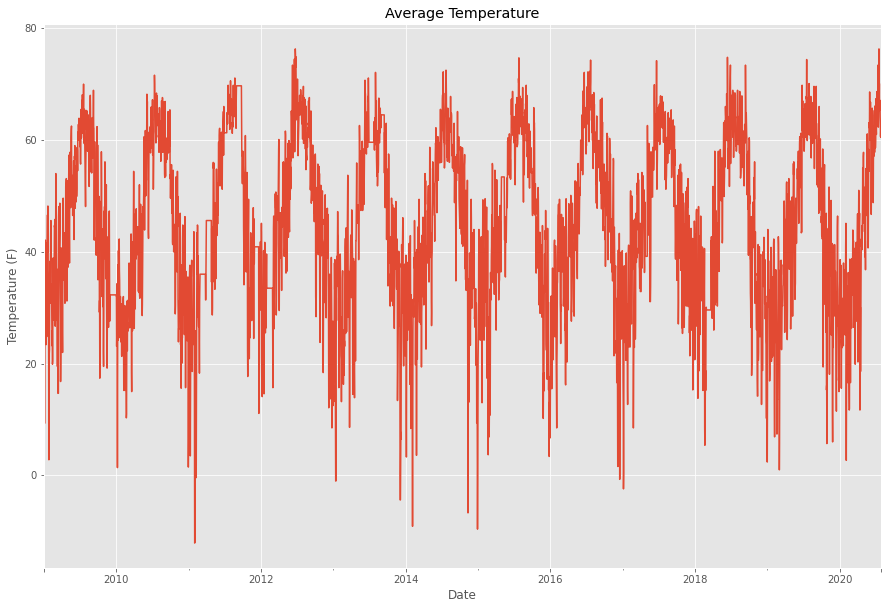

In [11]:
weatherGraph = weatherClean["Temperature"].plot(title = "Average Temperature") #Plot the temperature data
weatherGraph.set(ylabel = "Temperature (F)") #Put the temperature label

The filled values do not appear to be too noticable on the graph. I do not think it will cause very many issues.

---

# Visualizations

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6fc412f690>,
      dtype=object)

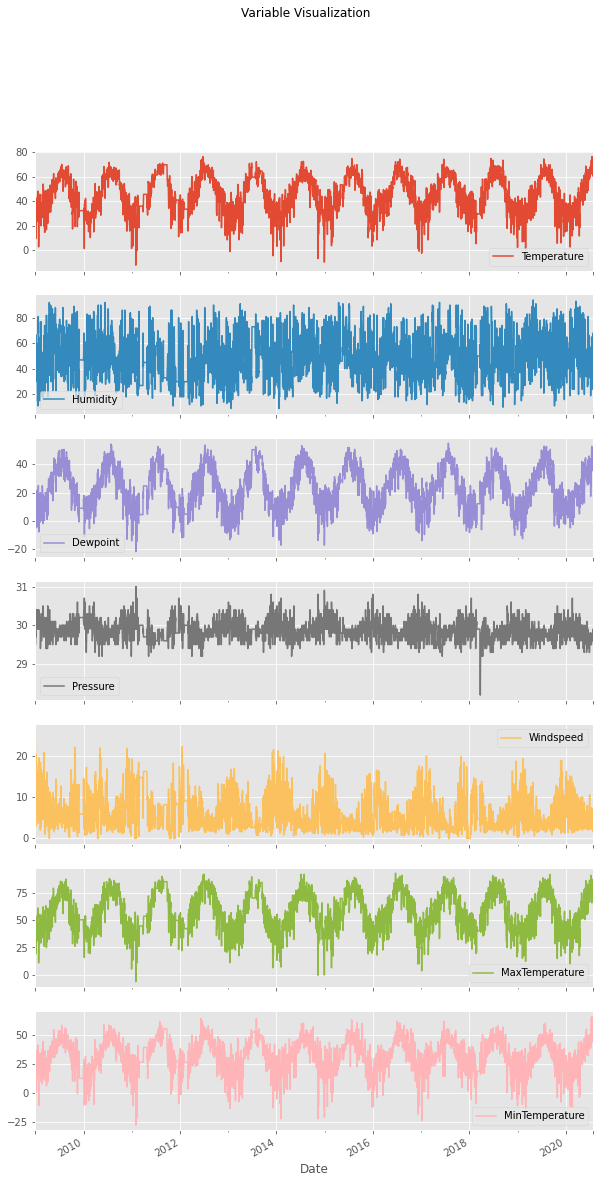

In [12]:
plt.rcParams['figure.figsize'] = (10,20) #Set the figure size
weatherClean.plot(subplots = True, title = "Variable Visualization") #Plot all the variables

[Text(0, 0.5, 'Temperature (F)')]

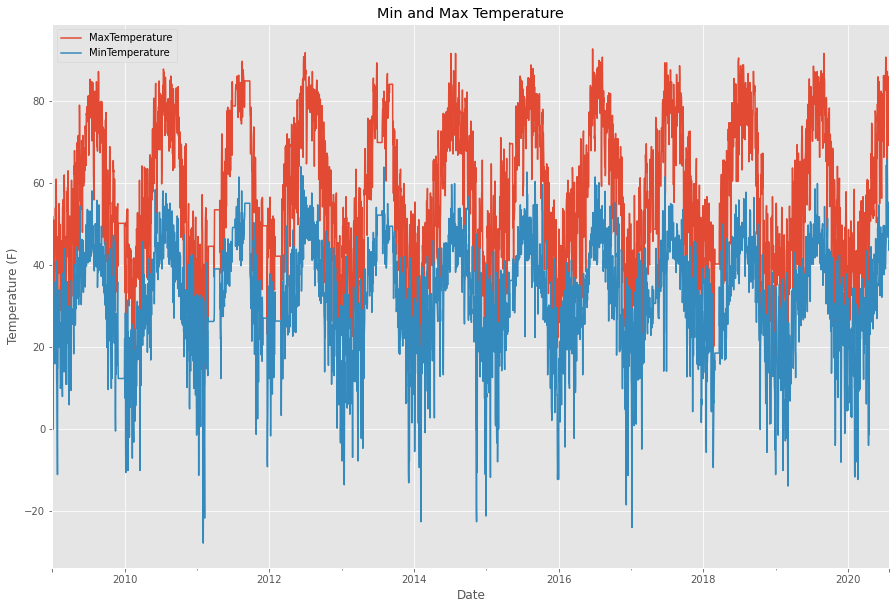

In [13]:
plt.rcParams['figure.figsize'] = (15,10) #Set the figure size for the min-max temperature graph
minmax = weatherClean[["MaxTemperature", "MinTemperature"]].plot(title = "Min and Max Temperature") #Plot the min and max temperatures
minmax.set(ylabel = "Temperature (F)") #Put the temperature label

The majority of these features have clear seasonality to them. The general trends still seem to be upheld despite the missing data issues, but the min max graph shows how some larger areas that had gaps in their data,specifically March-April of 2011.

---

# Causality

Using this source for causality and cointegration: https://www.kaggle.com/gayatry/daily-climate-forcast

In [14]:
columns = weatherClean.columns #Get the columns to use as both rows and columns
maxlag = 12 #The largest amount of lag allowable
test = "ssr_chi2test" #Making sure we are looking at the chi squarred test

cause = pd.DataFrame(np.zeros((len(columns), len(columns))), columns = columns, index = columns) #Build the layout for the causality

#For loop to fill the columns of the causality
for column in columns:
    
    #For loop to fill the rows of the causality, in conjunction with the column
    for row in columns:
        causality = grangercausalitytests(weatherClean[[row, column]], maxlag = maxlag,verbose = False) #Calculate causality values
        pValues = [round(causality[i+1][0][test][1],5) for i in range(maxlag)] #Collect all the p values in the max lag
        minValue = np.min(pValues) #Take the smallest P value
        cause.loc[row, column] = minValue #Put the smallest P value into the causalty

cause.head(7) #Show the causality

,Temperature,Humidity,Dewpoint,Pressure,Windspeed,MaxTemperature,MinTemperature
Temperature,1.0,0.0,0.0,0.0,0.00000,0.0,0.0
Humidity,0.0,1.0,0.0,0.0,0.00121,0.0,0.0
Dewpoint,0.0,0.0,1.0,0.0,0.00000,0.0,0.0
Pressure,0.0,0.0,0.0,1.0,0.00000,0.0,0.0
Windspeed,0.0,0.0,0.0,0.0,1.00000,0.0,0.0
MaxTemperature,0.0,0.0,0.0,0.0,0.00000,1.0,0.0
MinTemperature,0.0,0.0,0.0,0.0,0.00000,0.0,1.0


There is very little connection between these variables. That means VAR is not useful here. I am also not looking for one variable specifically, so a regular regression does not fit here. Thus, I will use ARIMA.

---

# Seasonal Decomposition

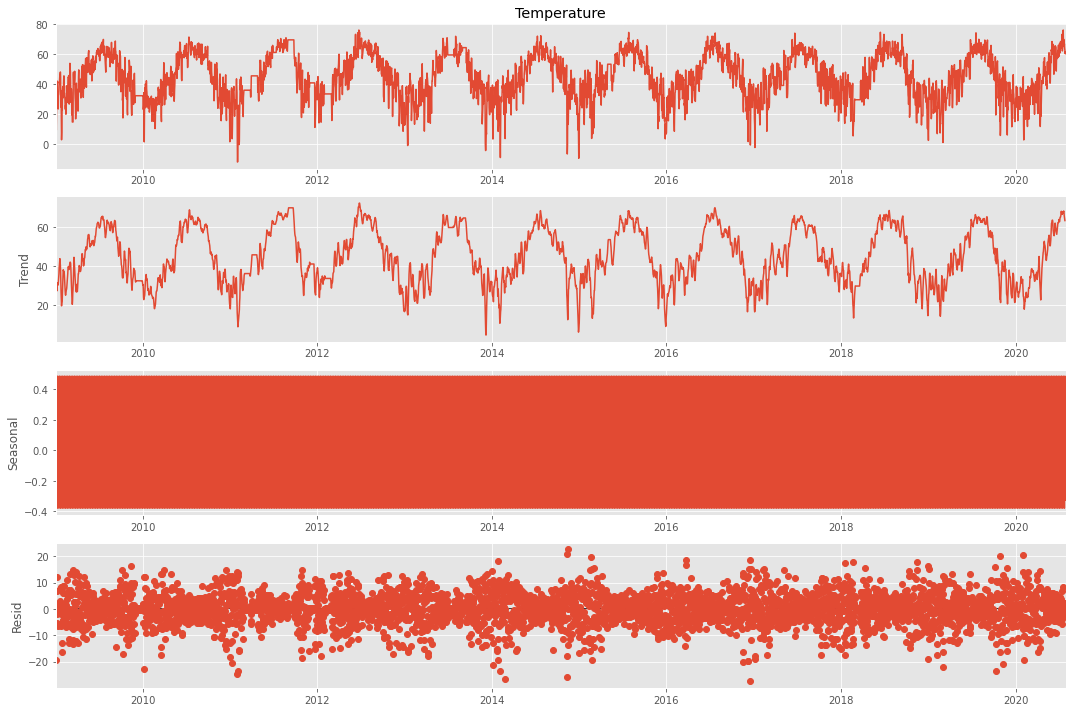

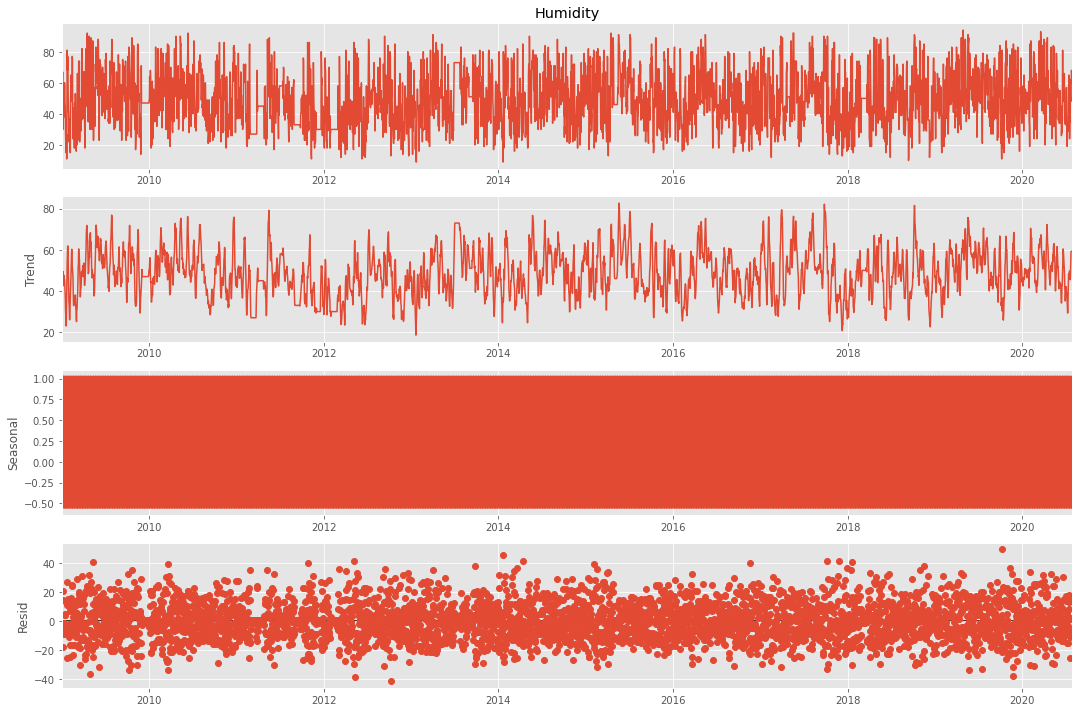

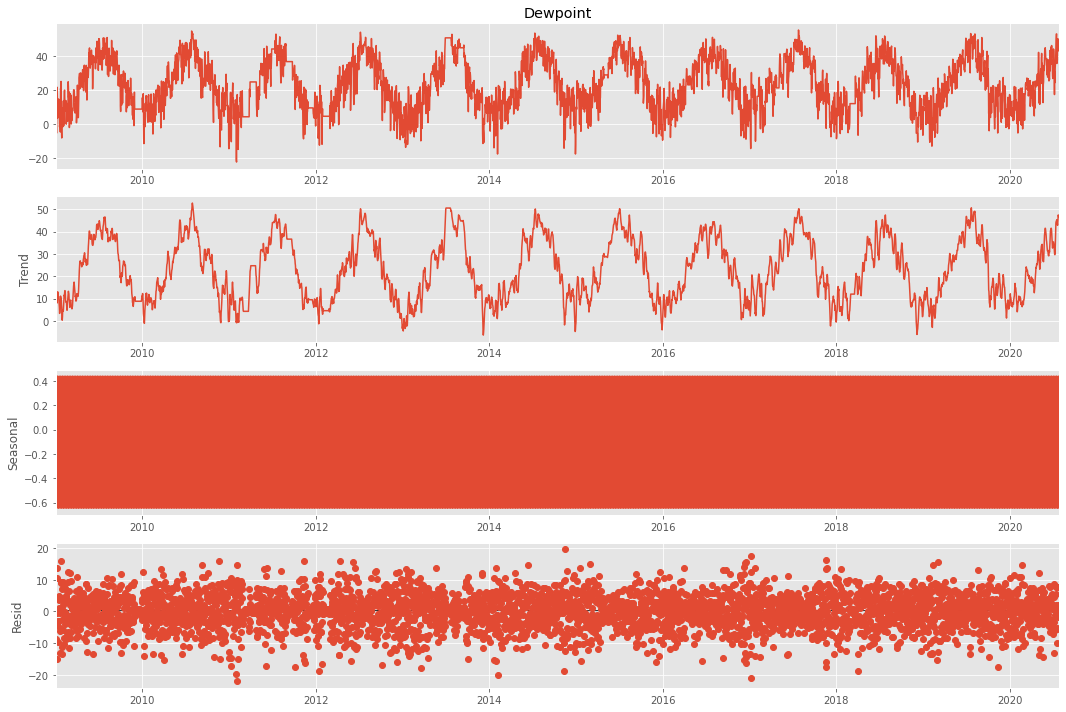

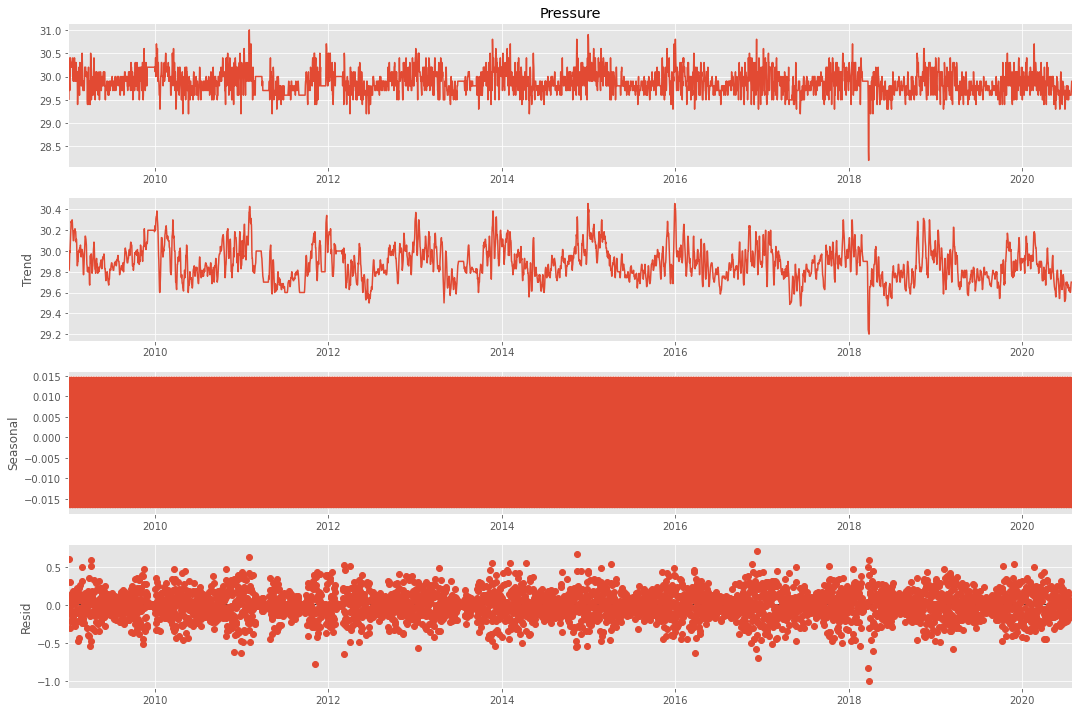

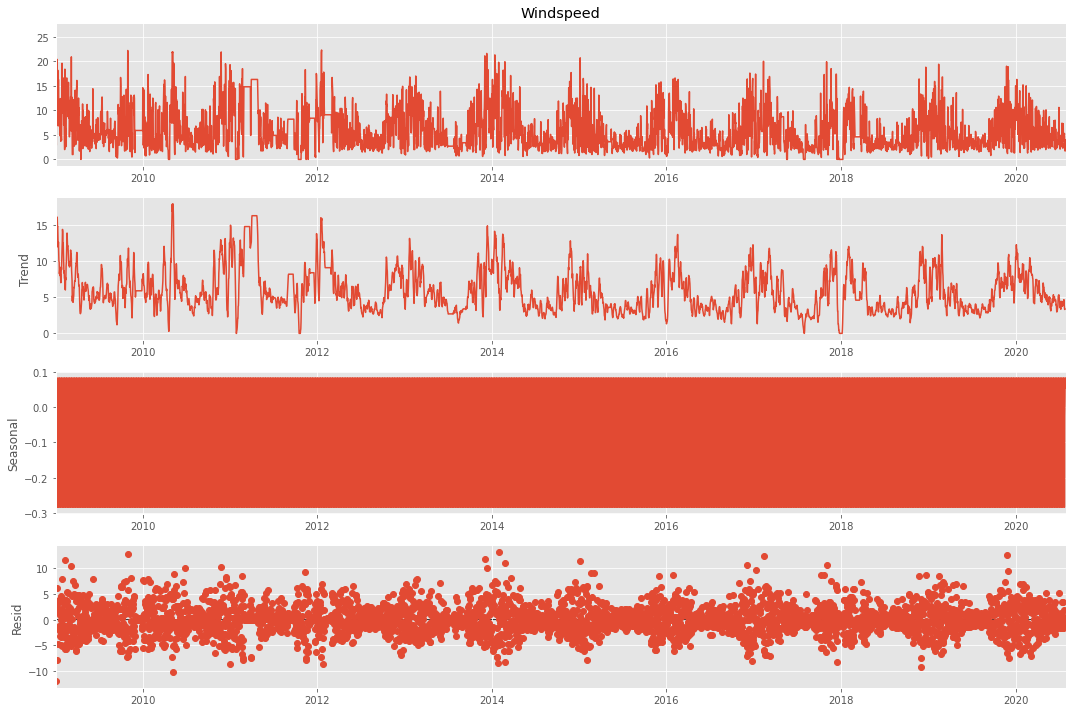

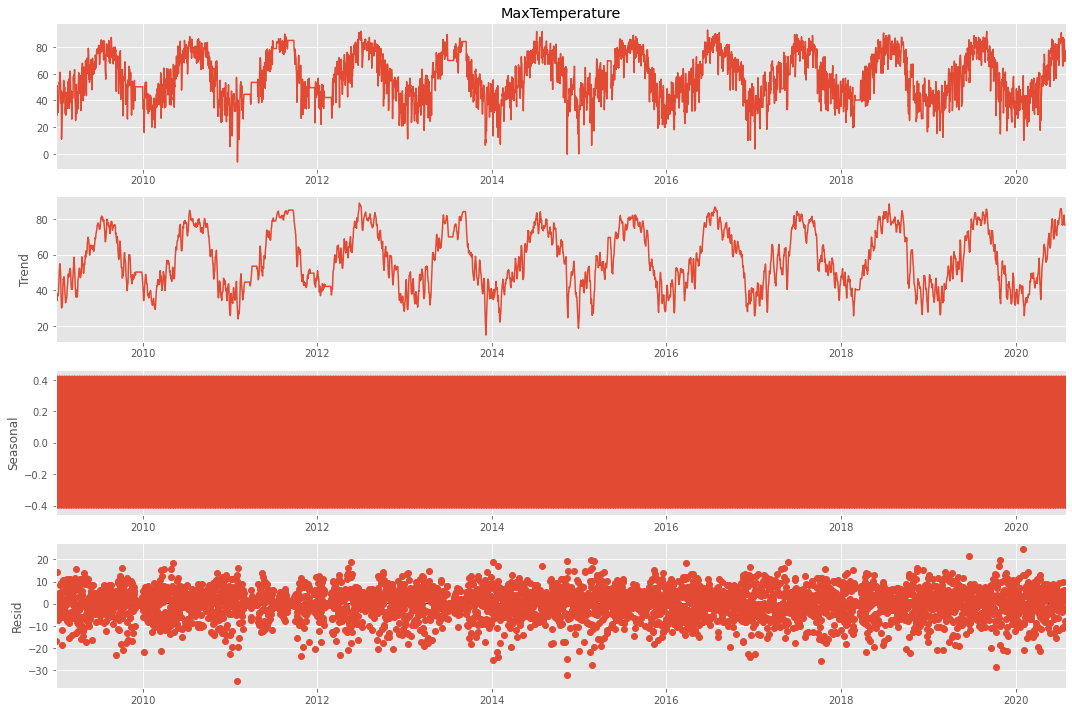

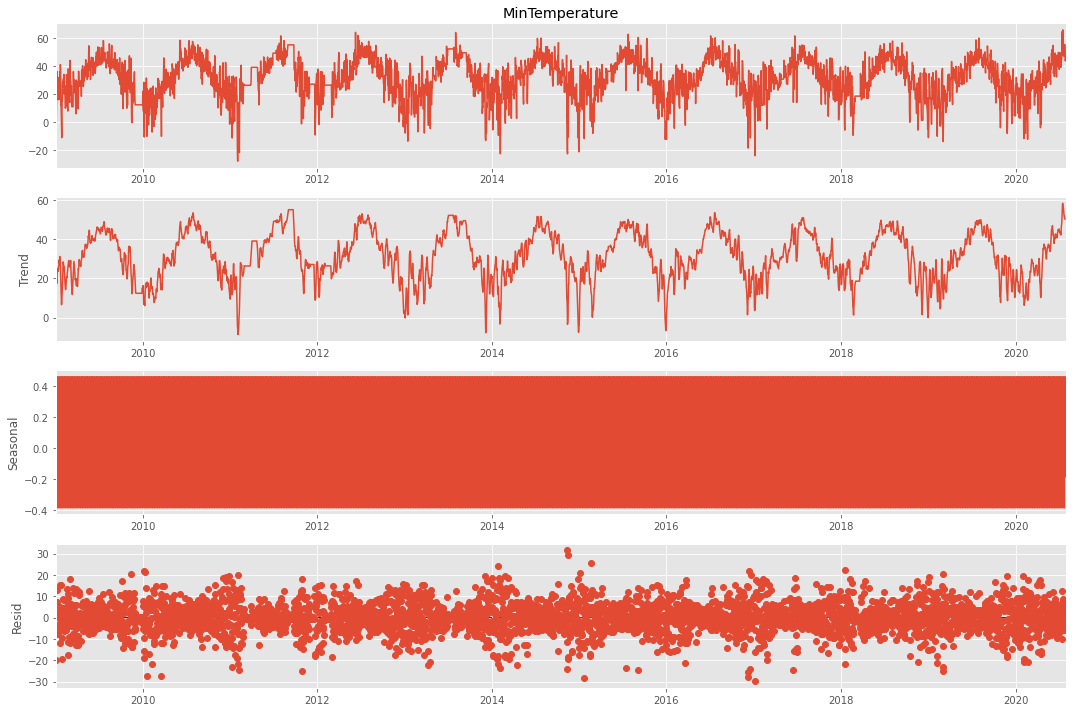

In [15]:
#For each column, decompose and plot the column
for column in columns:
    decomposed = seasonal_decompose(weatherClean[column]) #Seasonally decompose the set column
    x = decomposed.plot() #Plot the decomposed column

---

# ADFuller Stationary Testing

In [16]:
print("ADFuller Test; Significance: 0.05") #Print the significance level

#Do the ADFuller test for each column
for column in columns:
    adf = adfuller(weatherClean[column]) #Call adfuller to test
    print("ADF test static for {} is {}".format(column, adf[1])) #Print the adfuller results

ADFuller Test; Significance: 0.05
ADF test static for Temperature is 0.00011995140074475947
ADF test static for Humidity is 4.3747290778607995e-26
ADF test static for Dewpoint is 0.002177238107136308
ADF test static for Pressure is 2.4096717694689e-07
ADF test static for Windspeed is 6.909924882775198e-17
ADF test static for MaxTemperature is 0.0006144171243585119
ADF test static for MinTemperature is 6.684019972541914e-06


Every column tested below the significance level. The data is stationary.

---

# Training the Model (Dewpoint)

## Validation

In [17]:
length = int((len(weatherClean)*9)/10) #Get 9/10 of the length of the data
print(length) #Print the length to make sure it actually is an int
train = weatherClean[:length] #Split off the training set
test = weatherClean[length:] #Split off the testing set
dew = test["Dewpoint"] #Get the dewpoint data for the testing set
test = test.drop(columns = {"Dewpoint"}) #Drop the dewpoint so the model will not get mad

3804


In [18]:
model = SARIMAX(train["Dewpoint"], train.drop(columns = {"Dewpoint"})) #Build the SARIMAX model
fitModel = model.fit(disp = 1) #Fit the SARIMAx model

Text(0, 0.5, 'Temperature (F)')

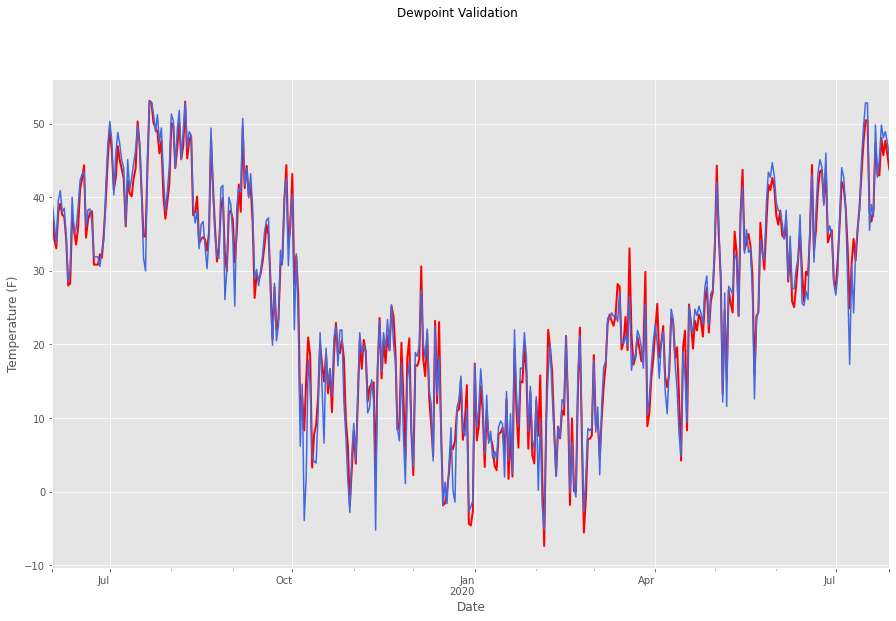

In [19]:
forecast = fitModel.forecast(len(weatherClean) - length, exog = test.values) #Forecast for validation data
ax = forecast.plot(subplots = True, color = "red", linewidth = 2, title = "Dewpoint Validation") #Plot the forecasted data
dew.plot(ax = ax, subplots = True, color = "royalblue") #Plot the actual dewpoint
plt.ylabel("Temperature (F)") #Put the temperature label

In [20]:
print("The Absolute Error of {} is {}".format("Dewpoint", mean_absolute_error(dew, forecast))) #Print the error

The Absolute Error of Dewpoint is 1.8177865602342296


The model is predicting with a small amount of error. This is fine.

## Forecasting

In [21]:
modelPred = SARIMAX(weatherClean["Dewpoint"], weatherClean.drop(columns = {"Dewpoint"})) #Build the prediction model
fitModelPred = modelPred.fit(disp = 1) #Fit the SARIMAX model

In [22]:
weatherNoDew = weatherClean.drop(columns = {"Dewpoint"}) #Get the weather data without the dewpoint
weatherNoDew = weatherNoDew[len(weatherClean) - 365:] #Limit the size so I can see it better in the graph
dewShort = dew[len(dew)-365:] #Get a shortened dew dataframe so details can be visible

Text(0, 0.5, 'Temperature (F)')

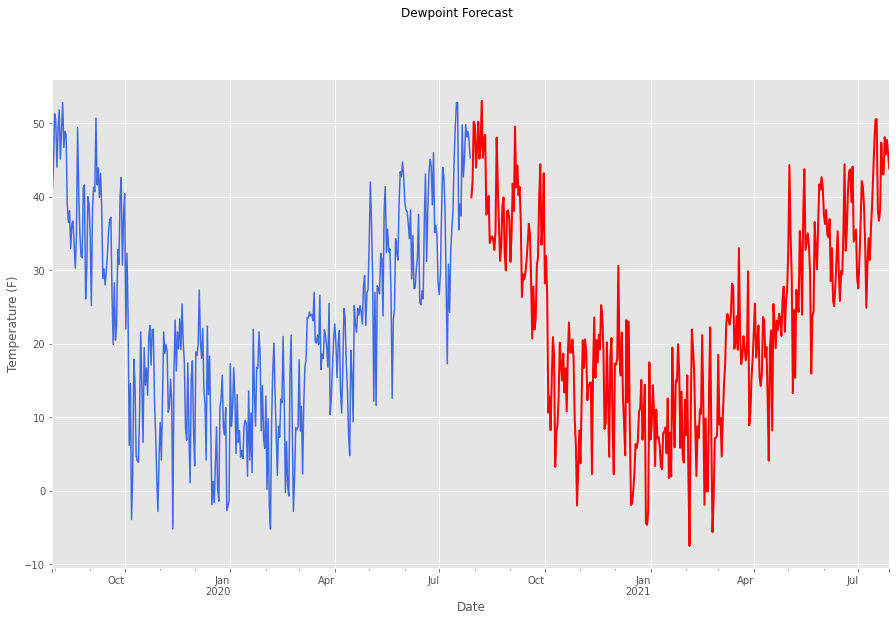

In [23]:
forecastDew = fitModelPred.forecast(steps = len(weatherNoDew), exog = weatherNoDew.values) #Forecast the next year
ax = forecastDew.plot(subplots = True, color = "red", linewidth = 2, title = "Dewpoint Forecast") #Plot the dew forecast
dewShort.plot(ax = ax, subplots = True, color = "royalblue") #Plot the shortened dew dataframe
plt.ylabel("Temperature (F)") #Put the temperature label

In [24]:
#https://www.estesparkweather.net/archive_reports.php?date=202011
print("Actual (Taken from the source): 5.7") #Print yesterday's the dewpoint from the source
print("Prediction: {}".format(forecastDew["2020-11-13"])) #Print the prediction for yesterday

Actual (Taken from the source): 5.7
Prediction: 23.57896492949675


The prediction for yesterday was off, but previous years had higher dewpoints for this day. It is off in the actual, but it a fair prediction based off other years.

---

# Training the Model (Temperature)

## Validation

In [25]:
trainTem = weatherClean[:length] #Get a training split
testTem = weatherClean[length:] #Get a testing split
temp = testTem["Temperature"] #Get the temperature data for graphing
testTem = testTem.drop(columns = {"Temperature"}) #Drop the temperature data to test the model

In [26]:
modelTemp = SARIMAX(trainTem["Temperature"], trainTem.drop(columns = {"Temperature"})) #Build the model
fitModelTemp = modelTemp.fit(disp = 1) #Fit the SARIMAX model

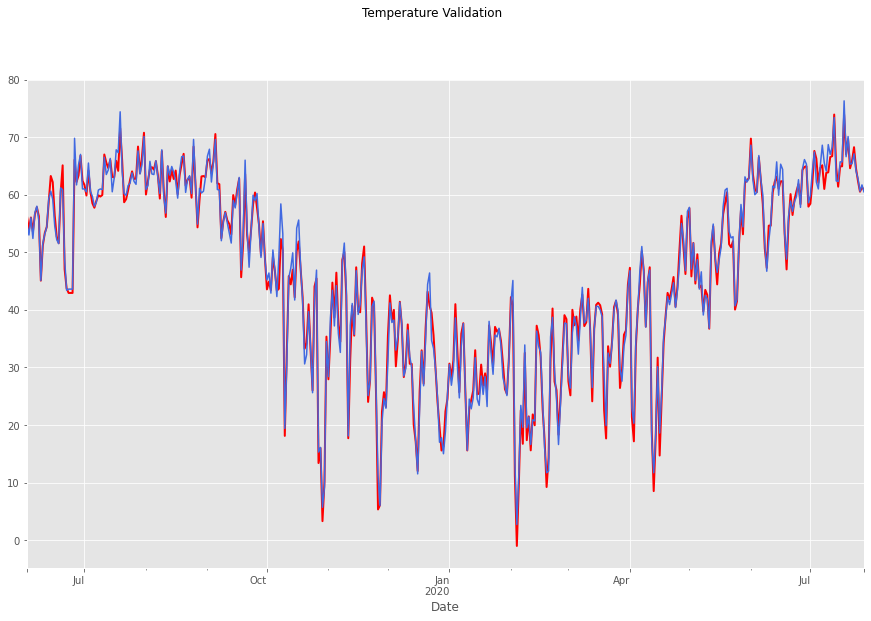

In [27]:
forecastTem = fitModelTemp.forecast(len(weatherClean) - length, exog = testTem.values) #Get the validation forecast
ax = forecastTem.plot(subplots = True, color = "red", linewidth = 2, title = "Temperature Validation") #Plot the validation data
temp.plot(ax = ax, subplots = True, color = "royalblue") #Plot the temperature for the test timeframe
plt.ylab = "Temperature (F)" #Put the temperature label

In [28]:
print("The Absolute Error of {} is {}".format("Temperature", mean_absolute_error(temp, forecastTem))) #Get the temperature error

The Absolute Error of Temperature is 1.2492056621864067


In [29]:
modelPredTemp = SARIMAX(weatherClean["Temperature"], weatherClean.drop(columns = {"Temperature"})) #Build the full temp model
fitModelPredTemp = modelPredTemp.fit(disp = 1) #Fit the SARIMAX model

In [30]:
weatherNoTemp = weatherClean.drop(columns = {"Temperature"}) #Drop the temperature column so the model does not get mad
weatherNoTemp = weatherNoTemp[len(weatherClean) - 365:] #Split a small section for the model
tempShort = temp[len(dew)-365:] #Get a shortened section for graphing

Text(0, 0.5, 'Temperature (F)')

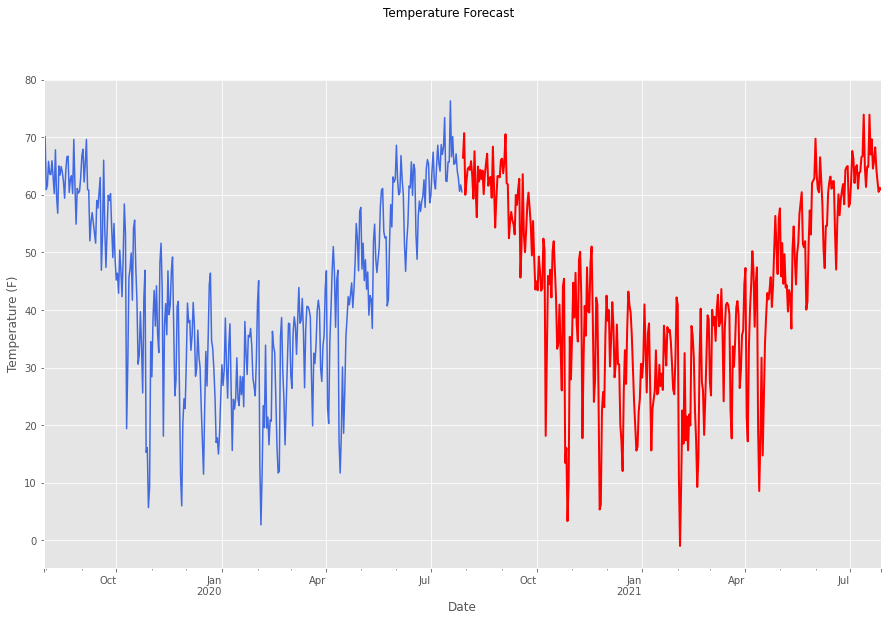

In [31]:
forecastTemp = fitModelPredTemp.forecast(steps = len(weatherNoTemp), exog = weatherNoTemp.values) #Predict the next year's temps
ax = forecastTemp.plot(subplots = True, color = "red", linewidth = 2, title = "Temperature Forecast") #Plot the temp forecast
tempShort.plot(ax = ax, subplots = True, color = "royalblue") #Plot the temperature to the forecast
plt.ylabel("Temperature (F)") #Put the temperature label

In [32]:
#https://www.estesparkweather.net/archive_reports.php?date=202011
print("Actual (Taken from the source): 38.2") #Print yesterday's actual temperature
print("Prediction: {}".format(forecastTemp["2020-11-13"])) #Print yesterday's prediction

Actual (Taken from the source): 38.2
Prediction: 35.53483406998533


---

# Conclusion

The predictions seem pretty accurate based on previous years. The dewpoint prediction for yesterday was off, but it was more akin to dewpoints of previous years. Yesterday's average temperature was well predicted.

The missing data issues did not seem to cause any problems with prediction. The vast volume of data likely negated these sections of filled in data. 